In [1]:
import numpy as np
import scipy.signal
import torch
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter
import torchaudio
import itertools
import tqdm
import torch.nn.functional as F
import scipy as sp
import torch.nn as nn
import fb

In [2]:
HYPERPARAMS = {
    "synth": {
        "N": 1024,
        "J": 10,
        "T": 64,
        "sr": 16000,
        "fmin": 64,
        "fmax": 8000,
        "batch_size": 32
    },
}

spec = HYPERPARAMS["synth"]

In [3]:
# create a random filterbank and its tightened version

w_init, w_tight = fb.random_filterbank(spec["N"], spec["J"], spec["T"], tight=True, to_torch=True)

In [4]:
synth = fb.generate_random_sine(
    spec["sr"],
    spec["fmin"],
    spec["fmax"],
    spec["N"],
    spec["batch_size"])

In [5]:
# conv1D layer with circulant boundary conditions

class TDFilterbank_real(torch.nn.Module):
    def __init__(self, spec, w_init):
        super().__init__()
        
        self.psi = torch.nn.Conv1d(
            in_channels=1,
            out_channels=spec["J"],
            kernel_size=spec["T"],
            stride=1,
            padding=0,
            bias=False)
        
        # initialize the filters to be w_init
        self.psi.weight.data = w_init[:, :spec["T"]].unsqueeze(1).float()
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[-1])
        x = F.pad(x, (0, spec["T"]-1), mode='circular',)
        Wx = self.psi(x)
        Ux = torch.abs(Wx)
        return Ux
    
baseline = TDFilterbank_real(spec, w_init)
print(baseline)

TDFilterbank_real(
  (psi): Conv1d(1, 10, kernel_size=(64,), stride=(1,), bias=False)
)


In [10]:
# loss functions with penalization terms

# penalizing large kappa

class CondLoss(nn.Module):
    def __init__(self):
        super(CondLoss, self).__init__()

    def forward(self, inputs, targets, w):
        w = torch.cat((w,torch.zeros([spec["J"], spec["N"]-spec["T"]])),dim=1)
        w_hat = torch.sum(torch.abs(torch.fft.fft(w,dim=1))**2,dim=0)
        Lam_max = torch.max(w_hat,dim=0).values
        Lam_min = torch.min(w_hat,dim=0).values
        loss = torch.mean(torch.abs(inputs - targets)**2) + 0.01*Lam_max/Lam_min
        return loss
    
# penalizing large ||W^T W - I||^2
    
class NormLoss(nn.Module):
    def __init__(self):
        super(NormLoss, self).__init__()

    def forward(self, inputs, targets, w):
        w = torch.cat((w,torch.zeros([spec["J"], spec["N"]-spec["T"]])),dim=1)
        W = fb.circulant(w)
        S = torch.matmul(W.T,W)
        I = torch.eye(S.shape[0])
        loss = torch.mean(torch.abs(inputs - targets)**2) + 0.01*torch.norm(S-I)**2
        return loss

In [11]:
# training function

def train(baseline, penalization, lr, n_epochs, epoch_size):
    optimizer = torch.optim.Adam(baseline.parameters(), lr=lr)
    mse = torch.nn.MSELoss()
    if penalization == 'mse':
        criterion = torch.nn.MSELoss() 
    if penalization == 'kappa':
        criterion = CondLoss() 
    if penalization == 'frameop':
        criterion = NormLoss() 
    losses = []
    conditions = []

    w = baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.concatenate((w,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
    A,B = fb.frame_bounds_lp(w)
    conditions.append(B/A)

    running_loss = 0.0
    for _ in range(epoch_size):
        inputs = next(synth)
        outputs = baseline(inputs)
        targets = fb.filterbank_response(inputs, w_tight)
        w = baseline.psi.weight[:,0,:]
        loss = mse(outputs, targets)
        running_loss += loss.item()
    print(1000 * running_loss)
    losses.append(running_loss)

    for _ in range(n_epochs):
        running_loss = 0.0
        for i in tqdm.tqdm(range(epoch_size)):
            inputs = next(synth)
            optimizer.zero_grad()
            outputs = baseline(inputs)
            targets = fb.filterbank_response(inputs, w_tight)
            if penalization == 'mse':
                loss = mse(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            if penalization == 'kappa':
                w = baseline.psi.weight[:,0,:]
                loss = criterion(outputs, targets, w)
                loss.backward()
                optimizer.step()
                loss2 = mse(outputs, targets)
                running_loss += loss2.item()
            if penalization == 'frameop':
                # use this loss only every 10th iteration
                if np.mod(i,10) == 0:
                    w = baseline.psi.weight[:,0,:]
                    loss = criterion(outputs, targets, w)
                    loss.backward()
                    optimizer.step()
                else:
                    loss = mse(outputs, targets)
                    loss.backward()
                    optimizer.step()                
                    loss2 = mse(outputs, targets)
                    running_loss += loss2.item()
        losses.append(running_loss)
        w = baseline.psi.weight.detach().numpy()[:,0,:]
        w = np.concatenate((w,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
        A,B = fb.frame_bounds_lp(w)
        conditions.append(B/A)
        print(1000 * running_loss)

    return losses, conditions

In [12]:
n_epochs = 10
epoch_size = 50
lr = 0.0001

baseline = TDFilterbank_real(spec, w_init)
losses_mse, conditions_mse = train(
    baseline=baseline,
    penalization='mse',
    lr=lr,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

baseline = TDFilterbank_real(spec, w_init)
losses_kappa, conditions_kappa = train(
    baseline=baseline,
    penalization='kappa',
    lr=lr,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

baseline = TDFilterbank_real(spec, w_init)
losses_fo, conditions_fo = train(
    baseline=baseline,
    penalization='frameop',
    lr=lr,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

58.958468318451196


100%|██████████| 50/50 [00:01<00:00, 33.62it/s]


35.98455953761004


100%|██████████| 50/50 [00:01<00:00, 34.04it/s]


21.49447551346384


100%|██████████| 50/50 [00:02<00:00, 24.76it/s]


16.45480823935941


100%|██████████| 50/50 [00:01<00:00, 28.27it/s]


16.38654203270562


100%|██████████| 50/50 [00:01<00:00, 32.45it/s]


15.965215148753487


100%|██████████| 50/50 [00:01<00:00, 31.58it/s]


15.271526222932152


100%|██████████| 50/50 [00:01<00:00, 25.60it/s]


14.73248066031374


100%|██████████| 50/50 [00:01<00:00, 34.41it/s]


14.796347750234418


100%|██████████| 50/50 [00:01<00:00, 27.46it/s]


14.768032473511994


100%|██████████| 50/50 [00:01<00:00, 25.59it/s]


14.87212056235876
57.106191641651094


100%|██████████| 50/50 [00:01<00:00, 29.75it/s]


50.719978811684996


100%|██████████| 50/50 [00:01<00:00, 28.16it/s]


38.83058903738856


100%|██████████| 50/50 [00:01<00:00, 28.79it/s]


30.029066023416817


100%|██████████| 50/50 [00:02<00:00, 19.81it/s]


25.77952793217264


100%|██████████| 50/50 [00:02<00:00, 21.44it/s]


24.71452543977648


100%|██████████| 50/50 [00:02<00:00, 23.48it/s]


25.72200068971142


100%|██████████| 50/50 [00:02<00:00, 21.73it/s]


27.7288002835121


100%|██████████| 50/50 [00:02<00:00, 23.29it/s]


30.327821208629757


100%|██████████| 50/50 [00:01<00:00, 28.39it/s]


32.539585925405845


100%|██████████| 50/50 [00:01<00:00, 30.22it/s]


35.72706980048679
62.0127139845863


100%|██████████| 50/50 [00:05<00:00,  8.86it/s]


45.72954005561769


100%|██████████| 50/50 [00:05<00:00,  8.86it/s]


33.64190654247068


100%|██████████| 50/50 [00:06<00:00,  8.13it/s]


27.472493587993085


100%|██████████| 50/50 [00:07<00:00,  7.14it/s]


26.544301043031737


100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


28.060524899046868


100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


30.09122604271397


100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


33.6167918285355


100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


35.75118927983567


100%|██████████| 50/50 [00:06<00:00,  7.54it/s]


41.30790999624878


100%|██████████| 50/50 [00:05<00:00,  8.38it/s]

43.372999352868646


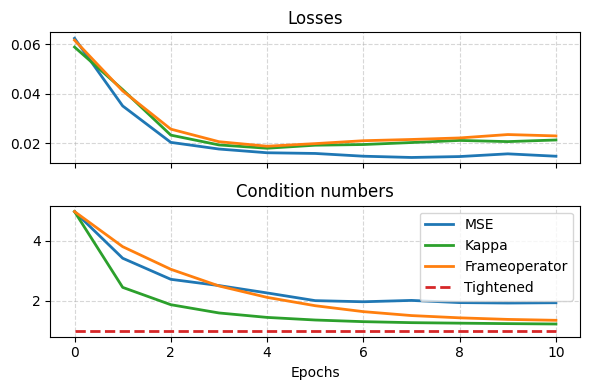

In [9]:
# plot losses and condition numbers over epochs

plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
Ts = np.arange(0, n_epochs+1)

ax = axes[0]
ax.plot(Ts, losses_mse, 'tab:blue', linewidth=2)
ax.plot(Ts, losses_kappa, 'tab:green', linewidth=2)
ax.plot(Ts, losses_fo, 'tab:orange', linewidth=2)

ax.set_title('Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, conditions_mse, 'tab:blue', linewidth=2, label='MSE')
ax.plot(Ts, conditions_kappa, 'tab:green', linewidth=2, label='Kappa')
ax.plot(Ts, conditions_fo, 'tab:orange', linewidth=2, label='Frameoperator')
ax.plot(Ts, np.ones(len(Ts)), 'tab:red', linewidth=2, label='Tightened', linestyle='--')

ax.set_title('Condition numbers')
ax.legend(loc='upper right')
ax.set_xlabel('Epochs')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Reproducing_Random_Tightness.pdf', bbox_inches='tight')